<h1>Data Preparation</h1>
This notebook downloads the sensor data from the server, selects data withiin specific date ranges, resamples data at specified time intervals and joins all processed sensor data in a single dataframe which can then be exported as a single csv file that will be used as inputs in other modules

In [1]:
import pandas as pd
import mysql.connector as sqlcn
import numpy as np
import matplotlib.pyplot as plt

import help_funcs.data_handlers as dh

plt.style.use('ggplot')
#plt.rcParams["figure.figsize"] = (18,14)

In [2]:
# Download data from database for each sensor and save each one in a dictionary
raw_data = dh.download_data()

c:\Users\vasil\miniconda3\envs\mlenv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\vasil\miniconda3\envs\mlenv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\vasil\miniconda3\envs\mlenv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\vasil\miniconda3\envs\mlenv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(

In [3]:
raw_data.keys()

dict_keys(['ext1', 'ext2', 'rta', 'ib_facade', 'ib_roof', 'libelium', 'arduino'])

In [4]:
resampled = dh.resample_dfs(raw_data, '1h', dh.resampling_rules)

In [5]:
def resample_df(raw_data):
    resampled = {}
    for k, v in raw_data.items():
        resampled[k] = v.resample('1h').mean()
    return resampled

In [6]:
#resampled = resample_df(raw_data)
resampled

{'ext1':                       air_temp  apperture
 datetime                                 
 2019-04-09 12:00:00  27.000000     5088.0
 2019-04-09 13:00:00        NaN        NaN
 2019-04-09 14:00:00        NaN        NaN
 2019-04-09 15:00:00  26.350000     5084.0
 2019-04-09 16:00:00        NaN        NaN
 ...                        ...        ...
 2023-04-29 16:00:00  27.400000     5161.0
 2023-04-29 17:00:00  27.316667     5161.0
 2023-04-29 18:00:00  27.300000     5161.0
 2023-04-29 19:00:00  27.300000     5161.0
 2023-04-29 20:00:00  27.300000     5160.0
 
 [35553 rows x 2 columns],
 'ext2':                       air_temp    apperture
 datetime                                   
 2019-04-09 12:00:00  26.600000  4096.000000
 2019-04-09 13:00:00        NaN          NaN
 2019-04-09 14:00:00        NaN          NaN
 2019-04-09 15:00:00  26.000000  4096.000000
 2019-04-09 16:00:00        NaN          NaN
 ...                        ...          ...
 2023-04-29 16:00:00  27.000000  417

In [7]:
joined = pd.concat(resampled.values(),keys=raw_data.keys(), axis=1)

new_columns = []
for col in joined.columns:
    new_col = f"{col[1]}_{col[0]}"
    new_columns.append(new_col)
joined.columns = new_columns

In [8]:
joined.to_csv("Prepared Datasets/Joined_Dataset.csv")

In [9]:
# For the YP extensometers calculate the aperture change for each time step
# This is needed to be consistent when resampling and avoid introducing
# drifts in apperture when resampling
raw_data['ext1']['aprtr_change'] = raw_data['ext1']['apperture'].diff()
raw_data['ext2']['aprtr_change'] = raw_data['ext2']['apperture'].diff()

In [10]:
data_2019 = dh.select_date_range(start_date='2019-04-15', stop_date='2019-08-16', df_dict=raw_data)
data_2022_bm = dh.select_date_range(start_date='2022-03-15', stop_date='2022-06-16', df_dict=raw_data)#.drop(['libelium', 'arduino'])
data_2022_am = dh.select_date_range(start_date='2022-08-25', df_dict=raw_data)#.drop(['libelium', 'arduino'])

resmpl_2019 = dh.resample_dfs(data_2019, '1h', dh.resampling_rules)
resmpl_2022_bm = dh.resample_dfs(data_2022_bm, '1h', dh.resampling_rules)
resmpl_2022_am = dh.resample_dfs(data_2022_am, '1h', dh.resampling_rules)

joined_2019 = dh.join_data(resmpl_2019)
joined_2022_bm = dh.join_data(resmpl_2022_bm)
joined_2022_am = dh.join_data(resmpl_2022_am, exclude='arduino')

['ext1', 'ext2', 'rta', 'ib_facade', 'ib_roof']
['ext1', 'ib_facade', 'ib_roof']
['ext1', 'ext2', 'rta', 'ib_facade', 'ib_roof', 'libelium', 'arduino']


In [11]:
def join_data(dfs):
    
    for instrument, df in dfs.items():
        print(df.columns)
        df.columns = [f"{col}_{instrument}" for col in df.columns]
        print(df.columns)
    # resample each dataframe to hourly intervals and calculate mean
    for instrument, df in dfs.items():
        dfs[instrument] = df.resample('H').mean()

    # concatenate dataframes and fill missing values with NaN
    df_combined = pd.concat(dfs.values(), axis=1, join='outer')

    # sort dataframe by timestamp
    df_combined = df_combined.sort_index(axis=1)

    # remove the extra level of column names added by the 'keys' parameter
    # df_combined.columns = df_combined.columns.droplevel(1)

    return df_combined

In [12]:
joined = join_data(raw_data)

Index(['air_temp', 'apperture', 'aprtr_change'], dtype='object')
Index(['air_temp_ext1', 'apperture_ext1', 'aprtr_change_ext1'], dtype='object')
Index(['air_temp', 'apperture', 'aprtr_change'], dtype='object')
Index(['air_temp_ext2', 'apperture_ext2', 'aprtr_change_ext2'], dtype='object')
Index(['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11'], dtype='object')
Index(['t1_rta', 't2_rta', 't3_rta', 't4_rta', 't5_rta', 't6_rta', 't7_rta',
       't8_rta', 't9_rta', 't10_rta', 't11_rta'],
      dtype='object')
Index(['air_temp', 'r_humid'], dtype='object')
Index(['air_temp_ib_facade', 'r_humid_ib_facade'], dtype='object')
Index(['air_temp', 'r_humid'], dtype='object')
Index(['air_temp_ib_roof', 'r_humid_ib_roof'], dtype='object')
Index(['epoch_time', 'battery_level', 'dendrometer', 'air_temp', 'r_humid',
       'atm_p', 'rock_temp', 'voltage'],
      dtype='object')
Index(['epoch_time_libelium', 'battery_level_libelium', 'dendrometer_libelium',
       'air_temp_libelium'

In [13]:
joined

,air_temp_ext1,air_temp_ext2,air_temp_ib_facade,air_temp_ib_roof,air_temp_libelium,apperture_ext1,apperture_ext2,aprtr_change_ext1,aprtr_change_ext2,atm_p_libelium,...,t4_arduino,t4_rta,t5_arduino,t5_rta,t6_arduino,t6_rta,t7_rta,t8_rta,t9_rta,voltage_libelium
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-08 09:00:00,NaN,NaN,NaN,28.815,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08 10:00:00,NaN,NaN,NaN,30.285,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08 11:00:00,NaN,NaN,29.750,31.755,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08 12:00:00,NaN,NaN,30.725,33.225,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08 13:00:00,NaN,NaN,31.695,34.700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-29 16:00:00,27.400000,27.000000,NaN,NaN,27.9,5161.000000,4171.666667,0.000000,0.000000,99.600000,...,26.86,26.9,26.80,27.083333,26.81,27.05,27.0,27.1,27.083333,4.0
2023-04-29 17:00:00,27.316667,27.000000,NaN,NaN,27.9,5160.833333,4171.666667,-0.166667,0.166667,99.683333,...,26.86,26.9,26.80,27.050000,26.81,27.00,27.0,27.1,27.083333,4.0
2023-04-29 18:00:00,27.300000,27.000000,NaN,NaN,27.9,5160.833333,4172.000000,0.000000,0.000000,99.700000,...,26.87,26.9,26.81,27.000000,26.81,27.00,27.0,27.1,27.016667,4.0


<Axes: xlabel='datetime'>

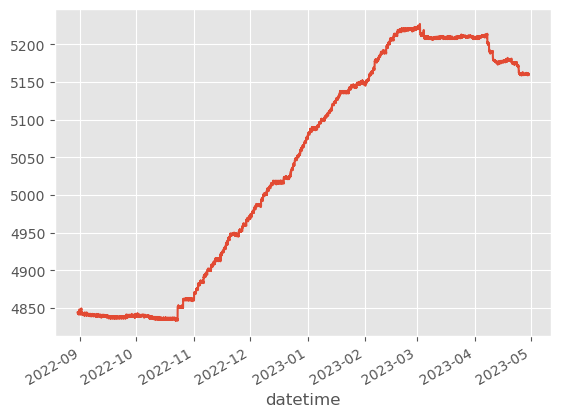

In [14]:
data_2022_am['ext1']['apperture'].plot()


<Axes: xlabel='datetime'>

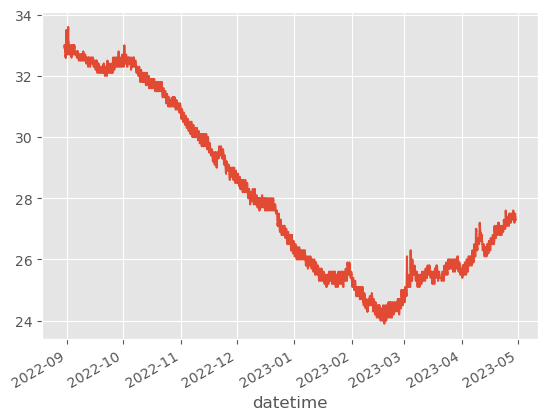

In [15]:
data_2022_am['ext1']['air_temp'].plot()

In [16]:
joined_2019.to_csv('./Prepared Datasets/Mar2019Aug2019rs1h.csv')
joined_2022_bm.to_csv('./Prepared Datasets/Mar2022Jun2022rs1h.csv')
joined_2022_am.to_csv('./Prepared Datasets/Aug2022Dec2022rs1h.csv')

joined_2022_am.columns

Index(['air_temp_ext1', 'apperture_ext1', 'air_temp_ext2', 'apperture_ext2',
       't1_rta', 't2_rta', 't3_rta', 't4_rta', 't5_rta', 't6_rta', 't7_rta',
       't8_rta', 't9_rta', 't11_rta', 'air_temp_ib_facade',
       'r_humid_ib_facade', 'air_temp_ib_roof', 'r_humid_ib_roof',
       'epoch_time_libelium', 'battery_level_libelium', 'dendrometer_libelium',
       'air_temp_libelium', 'r_humid_libelium', 'atm_p_libelium',
       'rock_temp_libelium', 'voltage_libelium'],
      dtype='object')

<Axes: xlabel='datetime'>

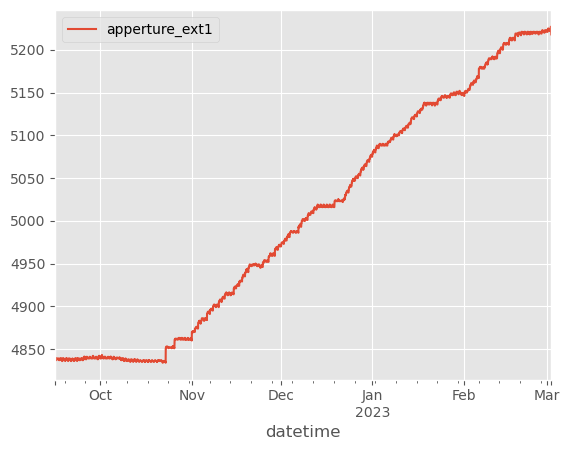

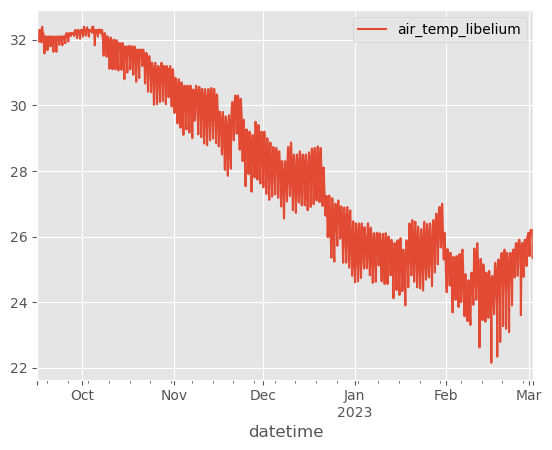

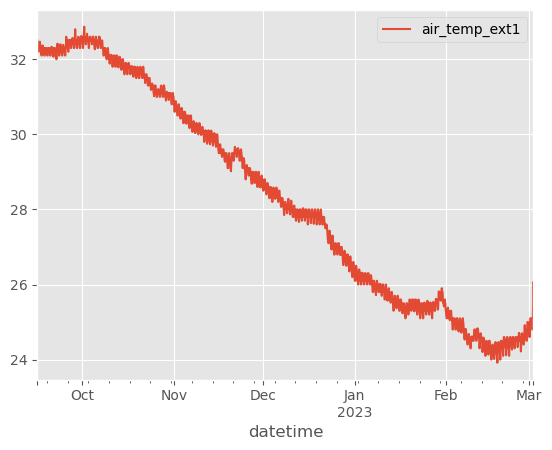

In [17]:
joined_2022_am.loc[:, ['apperture_ext1']].plot()
joined_2022_am.loc[:, ['air_temp_libelium']].plot()
joined_2022_am.loc[:, ['air_temp_ext1']].plot()

In [54]:
raw_data['ib_facade'].loc[:'2021-01-01'].sort_index()

,air_temp_ib_facade,r_humid_ib_facade
datetime,,
2019-04-08 11:00:00,29.750,30.685
2019-04-08 12:00:00,30.725,28.650
2019-04-08 13:00:00,31.695,26.615
2019-04-08 14:00:00,32.670,24.580
2019-04-08 15:00:00,33.645,22.540
...,...,...
2021-01-01 19:00:00,NaN,NaN
2021-01-01 20:00:00,NaN,NaN
2021-01-01 21:00:00,NaN,NaN
